# Semi Conductor Stock Market Analysis 

Use LSTM to collect and predict future stock prices

Introduction of other factors to the stock analysis process

Stock market prediction based on the performance of other stocks in the market in the same category

Depending on the perforamnce of other stocks such as Nvidia, AMD, etc. then the output should change

In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime

import yfinance as yf

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, LSTM

# yf.pdr_override() # deprecated

# Single Stock Prediction 

Use just the stock's closing price to predict the next opening price

## Code and Model

In [49]:
# Define the stock symbol and date range
stock_symbol = 'NVDA'
end = datetime.now()
start = datetime(end.year - 5, end.month, end.day)

# Fetch data for the stock
df = yf.download(stock_symbol, start=start, end=end)

# Flatten the column MultiIndex
df.columns = [col[0] for col in df.columns]  # Keep only the first level of the header

# makes Close accessible by removed the other header level
data = df.filter(['Close'])

# Convert to numpy array
dataset = data.values


[*********************100%***********************]  1 of 1 completed


In [50]:
df.head()

,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2019-12-03,5.170184,5.19150,5.19550,5.00925,5.04675,465232000
2019-12-04,5.214003,5.23550,5.29800,5.20675,5.27550,273424000
2019-12-05,5.197072,5.21850,5.27325,5.18775,5.25750,184884000
2019-12-06,5.282469,5.30425,5.33725,5.27800,5.28800,232236000
2019-12-09,5.282469,5.30425,5.35925,5.27250,5.28125,211880000


In [51]:
def preprocess_data(stock_symbol, epochs=100, batch_size=32, window_size=60):
    # Fetch data
    end = datetime.now()
    start = datetime(end.year - 5, end.month, end.day)

    # Fetch data for multiple stocks for the last 5 years
    df = yf.download(stock_symbol, start=start, end=end)

    # Flatten the column MultiIndex
    df.columns = [col[0] for col in df.columns]  # Keep only the first level of the header

    # Now, 'Close' will be accessible directly
    data = df.filter(['Close'])

    # Convert to numpy array
    dataset = data.values

    # split training data
    training_data_len = int(np.ceil(len(dataset) * .95))

    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(dataset)

    X, y = [], []
    for i in range(len(scaled_data) - window_size):
        X.append(scaled_data[i:i+window_size])
        y.append(scaled_data[i+window_size])

    X, y = np.array(X), np.array(y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
    ])
    
    model.compile(optimizer='adam', loss='mse')

    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=0)

    # Make predictions
    test_data = scaled_data[training_data_len - window_size:, :]
    test_set = []
    for i in range(window_size, len(test_data)):
        test_set.append(test_data[i-window_size:i, 0])

    test_set = np.array(test_set)
    test_set = np.reshape(test_set, (test_set.shape[0], test_set.shape[1], 1))

    prediction = model.predict(test_set)
    scaled_pred = scaler.inverse_transform(prediction)

    # Prepare results
    valid = data[training_data_len:]
    valid['Predictions'] = scaled_pred

    return df, valid, scaled_pred

In [52]:
df_nvda_5, valid_nvda, pred_nvda = preprocess_data('NVDA')

[*********************100%***********************]  1 of 1 completed


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 314ms/step


In [53]:
valid_nvda

,Close,Predictions
Date,,
2024-09-06,102.830002,109.214767
2024-09-09,106.470001,106.114044
2024-09-10,108.099998,107.904388
2024-09-11,116.910004,109.827065
2024-09-12,119.139999,117.136047
...,...,...
2024-11-26,136.919998,137.264648
2024-11-27,135.339996,137.711914
2024-11-29,138.250000,136.884323


In [54]:
r2 = r2_score(valid_nvda['Close'], valid_nvda['Predictions'])
print(f'R2 Score: {r2}')

R2 Score: 0.9210555378252059


## Output

In [55]:
current_price = df_nvda_5['Close'].iloc[-1]
threshold = 0.03

# predicted_price = float(pred_nvda[-1])
predicted_price = valid_nvda['Predictions'].iloc[-1]

# Decision logic
price_change = (predicted_price - current_price) / current_price  # Calculate % change
if price_change > threshold:
    action = "Buy"
elif price_change < -threshold:
    action = "Sell"
else:
    action = "Hold"

# Print the decision
print(f"Predicted Price: ${predicted_price:.2f}")
print(f"Current Price: ${current_price:.2f}")
print(f"Price Change: {price_change:.2%}")
print(f"Decision: {action}")

Predicted Price: $140.14
Current Price: $140.26
Price Change: -0.09%
Decision: Hold


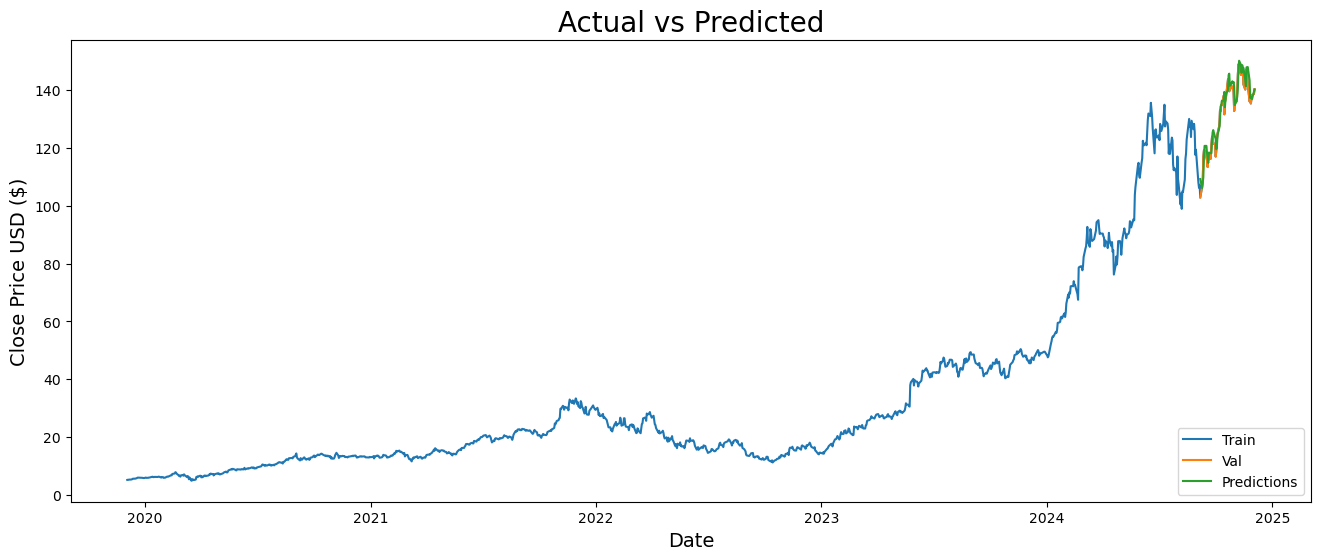

In [56]:
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Actual vs Predicted', fontsize=20)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Close Price USD ($)', fontsize=14)
plt.plot(df_nvda_5['Close'])
plt.plot(valid_nvda[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

# Stock Prediction using influence of other Stocks

Take closing prices of relevent stocks to influence opening stock price calculation for a target stock

## Code and Model

In [91]:
# use the Nasdaq index as a macroeconomic indicator (API cost tokens for NASDAQ)

# stock prediction focuses semiconductor stocks

# semiconductor stocks
# nvidia, taiwan semiconductor manufacturing, broadcom, qualcomm, AMD

# 5 years
stock_list = ['NVDA','TSM', 'AVGO', 'QCOM', 'AMD']

# target_symbol = 'NVDA'

In [ ]:
def stock_model(stock_list, target_symbol):
    # Fetch data for multiple stocks for 5 years
    end = datetime.now()
    start = datetime(end.year - 5, end.month, end.day)

    # Fetch data for multiple stocks for the last 5 years
    data = yf.download(stock_list, start=start, end=end)

    # data.head()

    stock_data = data['Close']

    # Separate the target stock (NVDA) and other stocks
    target_data = stock_data[target_symbol]  # The target stock data (NVDA)
    other_stocks_data = stock_data.drop(columns=[target_symbol])  # All other stocks

    # Combine the data: We want the target stock's history based on all other stocks
    dataset = pd.concat([other_stocks_data, target_data], axis=1).values

    # Calculate the length for training data
    training_data_len = int(np.ceil(len(dataset) * .95))

    # Scale the data using MinMaxScaler
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(dataset)

    window_size = 60 # number of days to consider

    # Prepare the feature (X) and target (y) sequences
    X, y = [], []
    for i in range(len(scaled_data) - window_size):
        X.append(scaled_data[i:i+window_size, :-1])  # All stock data for the window, excluding target stock
        y.append(scaled_data[i+window_size, -1])  # Target stock's next day close price, the last column


    # Convert the lists into numpy arrays
    X, y = np.array(X), np.array(y)

    # Split the data into training and testing sets (80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = Sequential([
        LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
        LSTM(64, return_sequences=False),
        Dense(25),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mse')

    epochs = 100
    batch_size = 32

    # Train the model
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=0)

    # Make predictions
    test_data = scaled_data[training_data_len - window_size:, :]
    test_set = []
    for i in range(window_size, len(test_data)):
        test_set.append(test_data[i - window_size:i, :-1])  # Use the history of other stocks

    test_set = np.array(test_set)
    test_set = np.reshape(test_set, (test_set.shape[0], test_set.shape[1], test_set.shape[2]))

    # Prediction
    prediction = model.predict(test_set)

    # Reshape the prediction to (num_samples, 1) for inverse transformation
    prediction = prediction.reshape(-1, 1)  # Flatten the output for inverse transformation

    # Inverse transform the predictions for the target stock (the last column)
    scaled_pred = scaler.inverse_transform(np.hstack([np.zeros((prediction.shape[0], scaled_data.shape[1] - 1)), prediction]))

    # Prepare results for the target stock
    valid = target_data[training_data_len:]
    valid = valid.to_frame()  # Convert to DataFrame, in the case the data is a series
    valid['Predictions'] = scaled_pred[:, -1]  # Only take the last column for the target stock

    return valid, training_data_len, data


## Code Split up

In [58]:
# Fetch data for multiple stocks for 5 years
end = datetime.now()
start = datetime(end.year - 5, end.month, end.day)

# Fetch data for multiple stocks for the last 5 years
data = yf.download(stock_list, start=start, end=end)

# data.head()

stock_data = data['Close']

[*********************100%***********************]  5 of 5 completed


In [59]:
# Separate the target stock (NVDA) and other stocks
target_data = stock_data[target_symbol]  # The target stock data (NVDA)
other_stocks_data = stock_data.drop(columns=[target_symbol])  # All other stocks

# Combine the data: We want the target stock's history based on all other stocks
dataset = pd.concat([other_stocks_data, target_data], axis=1).values

In [60]:
# Calculate the length for training data
training_data_len = int(np.ceil(len(dataset) * .95))

# Scale the data using MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(dataset)

In [61]:
window_size = 60 # number of days to consider

# Prepare the feature (X) and target (y) sequences
X, y = [], []
for i in range(len(scaled_data) - window_size):
    X.append(scaled_data[i:i+window_size, :-1])  # All stock data for the window, excluding target stock
    y.append(scaled_data[i+window_size, -1])  # Target stock's next day close price, the last column


# Convert the lists into numpy arrays
X, y = np.array(X), np.array(y)

In [62]:
# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [63]:
# Build the LSTM model

# input shape (samples, timesteps, features)
# samples = number of data points
# timesteps = length of each sequence
# features = number of variables/features observed at each step

model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')


In [64]:
epochs = 100
batch_size = 32

# Train the model
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=0)

In [65]:
# Make predictions
test_data = scaled_data[training_data_len - window_size:, :]
test_set = []
for i in range(window_size, len(test_data)):
    test_set.append(test_data[i - window_size:i, :-1])  # Use the history of other stocks

test_set = np.array(test_set)
test_set = np.reshape(test_set, (test_set.shape[0], test_set.shape[1], test_set.shape[2]))

In [66]:
# Prediction
prediction = model.predict(test_set)

# Reshape the prediction to (num_samples, 1) for inverse transformation
prediction = prediction.reshape(-1, 1)  # Flatten the output for inverse transformation

# Inverse transform the predictions for the target stock (the last column)
scaled_pred = scaler.inverse_transform(np.hstack([np.zeros((prediction.shape[0], scaled_data.shape[1] - 1)), prediction]))

# Prepare results for the target stock
valid = target_data[training_data_len:]
valid = valid.to_frame()  # Convert to DataFrame, in the case the data is a series
valid['Predictions'] = scaled_pred[:, -1]  # Only take the last column for the target stock

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 335ms/step


In [67]:
valid.head()

,NVDA,Predictions
Date,,
2024-09-06,102.830002,116.489831
2024-09-09,106.470001,113.875878
2024-09-10,108.099998,113.119499
2024-09-11,116.910004,113.488657
2024-09-12,119.139999,115.676823


In [68]:
r2 = r2_score(valid['NVDA'], valid['Predictions'])
print(f'R2 Score: {r2}')

R2 Score: 0.7457015219140221


In [73]:
valid, training_data_len, data = stock_model(stock_list, stock_symbol)

[*********************100%***********************]  5 of 5 completed


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 319ms/step


Observations: 
Makes predictions for the target stock in the past 5 years and use of other stocks to compare prices and adjust final prediction. R2 score would indicate that the model is fairly accurate in predicting the target stock's price. However, it's important to note that this model doesn't take into account other factors such as news, only comparing and measuring prices of other stocks to adjust its final decision.

## Output

In [ ]:
valid_amd, trdf_amd, data_amd = stock_model(stock_list, 'AMD')

[*********************100%***********************]  5 of 5 completed


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 316ms/step


In [94]:
def rec_invest(valid, data):
    # Extract the last prediction as a scalar value
    predicted_price = valid['Predictions'].iloc[-1]

    # Get the current price (last adjusted close price)
    current_price = data['Close']['NVDA'].iloc[-1]

    # Define the threshold
    threshold = 0.03 

    # Decision logic
    price_change = (predicted_price - current_price) / current_price  # Calculate % change
    if price_change > threshold:
        action = "Buy"
    elif price_change < -threshold:
        action = "Sell"
    else:
        action = "Hold"

    # Print the decision
    print(f"Predicted Price: ${predicted_price:.2f}")
    print(f"Current Price: ${current_price:.2f}")
    print(f"Price Change: {price_change:.2%}")
    print(f"Decision: {action}")

In [95]:
def print_visual(data, training_data_len, valid, symbol):
    # Visualize the data
    plt.figure(figsize=(16,6))
    plt.title('Actual vs Predicted', fontsize=20)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Close Price USD ($)', fontsize=14)

    plt.plot(data[:training_data_len]['Close'], color='blue')
    plt.plot(data['Close'][symbol], label='Validation', color='green')
    plt.plot(valid['Predictions'], label='Predictions', color='red')
    plt.legend(loc='lower right', fontsize=12)
    plt.grid(True)
    plt.show()

In [96]:
rec_invest(valid_amd, data_amd)

Predicted Price: $139.86
Current Price: $140.26
Price Change: -0.29%
Decision: Hold


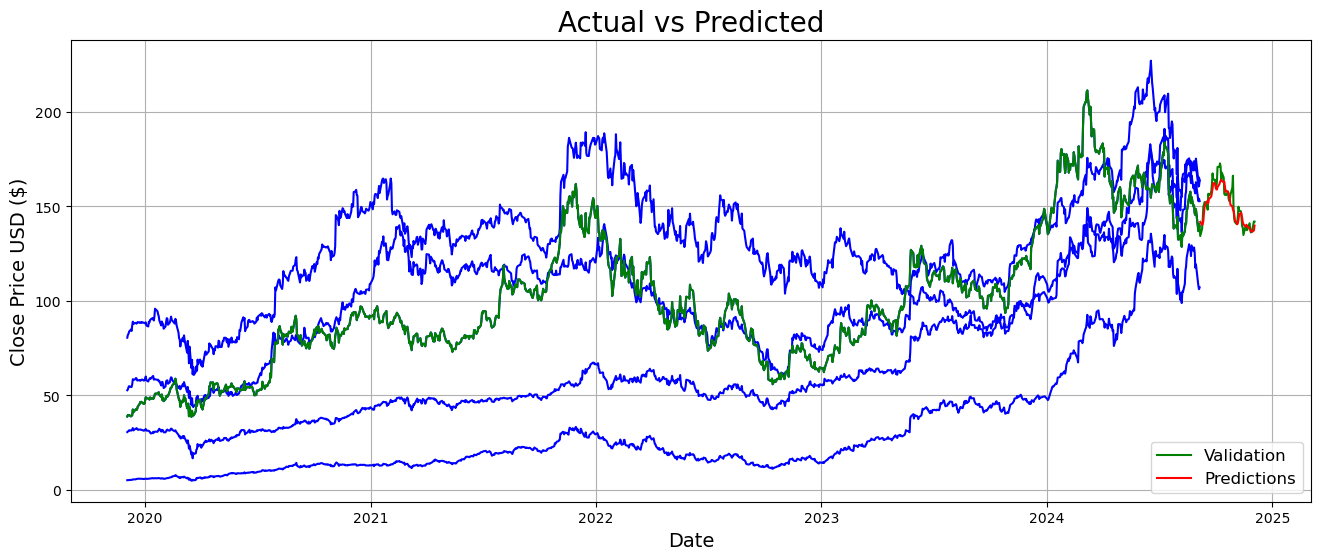

In [97]:
print_visual(data_amd, trdf_amd, valid_amd, 'AMD')

In [98]:
valid_nvda, trdf_nvda, data_nvda = stock_model(stock_list, 'NVDA')

[*********************100%***********************]  5 of 5 completed


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 346ms/step


In [99]:
rec_invest(valid_nvda, data_nvda)

Predicted Price: $139.27
Current Price: $140.26
Price Change: -0.71%
Decision: Hold


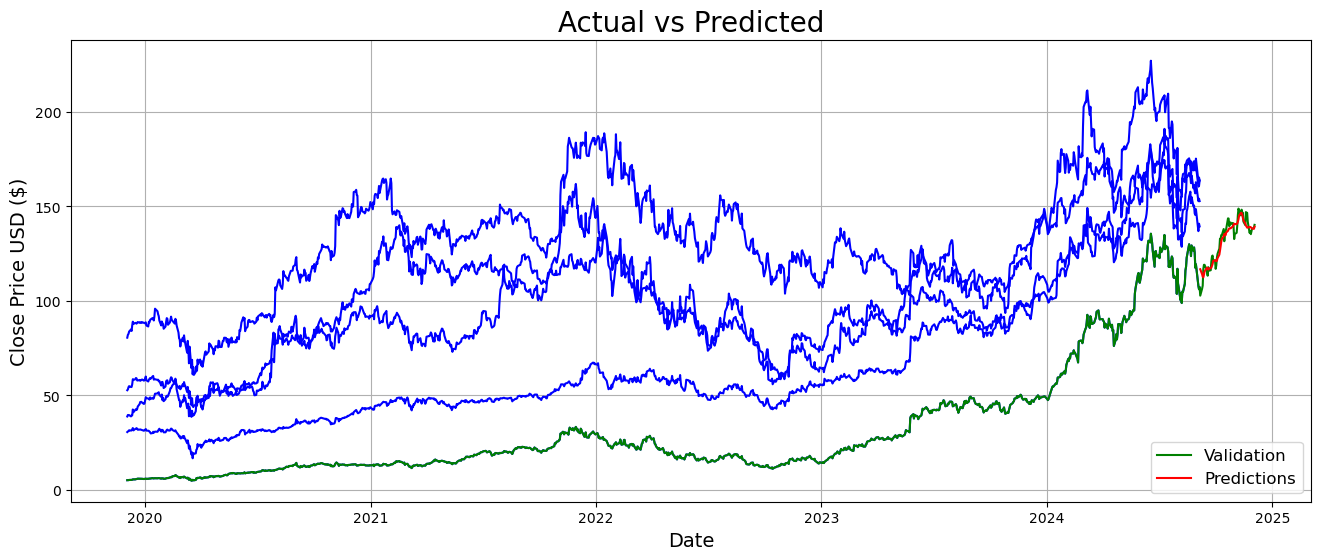

In [100]:
print_visual(data_nvda, trdf_nvda, valid_nvda, 'NVDA')